In [3]:
import torch
torch.cuda.is_available = lambda : False  # Prevent CUDA NMS error (forces CPU)

import cv2
import numpy as np
import requests
from PIL import Image
import io
from ultralytics import YOLO

jetbot_ip = '194.47.156.140'

KNOWN_WIDTH = 3.5  # cm, real object width
FOCAL_LENGTH = 500  # camera calibration

# Load YOLOv8 model (update path as needed!)
model = YOLO("runs/detect/train9/weights/best.pt")

def get_jetbot_frame(jetbot_ip):
    response = requests.get(f'http://{jetbot_ip}:8080/camera')
    image = Image.open(io.BytesIO(response.content))
    frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    return frame

while True:
    try:
        frame = get_jetbot_frame(jetbot_ip)

        # -------- YOLOv8 Inference --------
        results = model(frame)
        # results[0].boxes: .xyxy (N, 4), .conf (N), .cls (N)

        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            clss = result.boxes.cls.cpu().numpy()

            for (box, conf, cls_id) in zip(boxes, confs, clss):
                x1, y1, x2, y2 = map(int, box)
                w = x2 - x1
                h = y2 - y1
                # Draw rectangle
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 3)
                # Distance estimate
                distance_cm = (KNOWN_WIDTH * FOCAL_LENGTH) / max(w, 1)
                # Draw class/confidence
                label = f"Conf: {conf:.2f} Class: {int(cls_id)}"
                cv2.putText(frame, label, (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
                cv2.putText(frame, f"Distance: {distance_cm:.2f} cm", (x1, y2+25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

        # -------- Show window --------
        cv2.imshow("Jetbot YOLOv8 Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    except Exception as e:
        print(f"Error: {e}")

cv2.destroyAllWindows()



0: 224x224 (no detections), 70.0ms
Speed: 0.8ms preprocess, 70.0ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 40.7ms
Speed: 0.5ms preprocess, 40.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 67.7ms
Speed: 4.2ms preprocess, 67.7ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 42.9ms
Speed: 0.9ms preprocess, 42.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 59.5ms
Speed: 4.5ms preprocess, 59.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 47.4ms
Speed: 1.4ms preprocess, 47.4ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 40.6ms
Speed: 2.7ms preprocess, 40.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 47.7ms
Speed: 1.1ms preprocess, 47.7ms i

KeyboardInterrupt: 

Stream stopped.


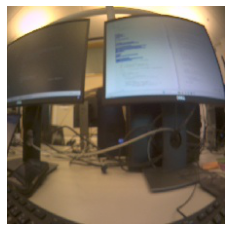

In [1]:
import requests
from PIL import Image
import io
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time

jetbot_ip = "194.47.156.140"  # Your Jetbot's IP

def get_jetbot_frame(jetbot_ip):
    response = requests.get(f'http://{jetbot_ip}:8080/camera', timeout=2)
    image = Image.open(io.BytesIO(response.content))
    frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    return frame

# Target frame duration for 24 fps
target_frame_time = 1.0 / 24

try:
    while True:
        start_time = time.time()

        try:
            frame = get_jetbot_frame(jetbot_ip)

            # ---- Your image processing here ----
            # For example, LAB thresholding as in your code:
            lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
            L, A, B = cv2.split(lab)
            _, mask = cv2.threshold(A, 150, 255, cv2.THRESH_BINARY)
            kernel = np.ones((5,5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                area = cv2.contourArea(contour)
                if area > 15:
                    x, y, w, h = cv2.boundingRect(contour)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
                    KNOWN_WIDTH = 3.5
                    FOCAL_LENGTH = 500
                    distance_cm = (KNOWN_WIDTH * FOCAL_LENGTH) / w
                    cv2.putText(frame, f"Distance: {distance_cm:.2f} cm", (x, y - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
            # ------------------------------------

            # Show image in notebook
            clear_output(wait=True)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            display(plt.gcf())
            plt.close()
        except Exception as e:
            print(f"Error: {e}")

        # Maintain 24 fps
        elapsed = time.time() - start_time
        sleep_time = max(0, target_frame_time - elapsed)
        time.sleep(sleep_time)

except KeyboardInterrupt:
    print("Stream stopped.")


In [6]:
import requests
from PIL import Image
import io
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time

jetbot_ip = "194.47.156.140"

# Define HSV color ranges
COLOR_RANGES = {
    "blue":   [(100, 80, 50), (130, 255, 255)],
    "red1":   [(0, 80, 50), (10, 255, 255)],
    "red2":   [(160, 80, 50), (180, 255, 255)],
    "orange": [(10, 80, 50), (25, 255, 255)],
    "yellow": [(20, 80, 50), (35, 255, 255)],
    "purple": [(130, 80, 50), (155, 255, 255)],
    "brown":  [(10, 60, 20), (20, 255, 200)],
}
LABELS = {
    "blue": ("Blue", (255, 0, 0)),
    "red1": ("Red", (0, 0, 255)),
    "red2": ("Red", (0, 0, 255)),
    "orange": ("Orange", (0, 128, 255)),
    "yellow": ("Yellow", (0, 255, 255)),
    "purple": ("Purple", (128, 0, 128)),
    "brown": ("Brown", (42, 42, 165)),
}

def get_jetbot_frame(jetbot_ip):
    response = requests.get(f'http://{jetbot_ip}:8080/camera', timeout=2)
    image = Image.open(io.BytesIO(response.content))
    frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    return frame

target_frame_time = 1.0 / 24  # 24 FPS

try:
    while True:
        start_time = time.time()
        frame = get_jetbot_frame(jetbot_ip)
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        result_frame = frame.copy()

        for color, (lower, upper) in COLOR_RANGES.items():
            lower = np.array(lower, dtype=np.uint8)
            upper = np.array(upper, dtype=np.uint8)
            mask = cv2.inRange(hsv, lower, upper)
            # Handle red wrap-around
            if color == "red1":
                mask1 = mask.copy()
            if color == "red2":
                mask = cv2.bitwise_or(mask1, mask)

            kernel = np.ones((7, 7), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area > 1000:
                    x, y, w, h = cv2.boundingRect(cnt)
                    label, color_draw = LABELS[color]
                    cv2.rectangle(result_frame, (x, y), (x + w, y + h), color_draw, 4)
                    cv2.putText(result_frame, label, (x, y - 12), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color_draw, 3)

        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        display(plt.gcf())
        plt.close()

        elapsed = time.time() - start_time
        sleep_time = max(0, target_frame_time - elapsed)
        time.sleep(sleep_time)

except KeyboardInterrupt:
    print("Stopped live color detection.")


Stopped live color detection.


<Figure size 432x288 with 0 Axes>

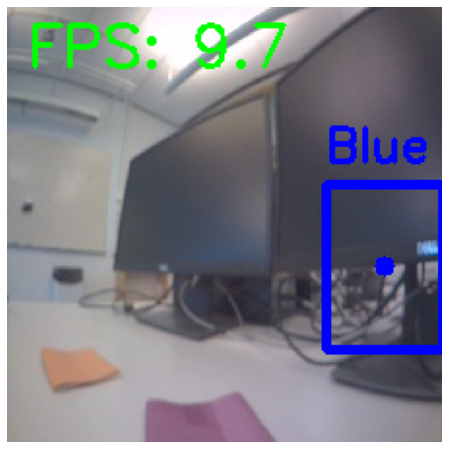

Stopped live color detection.


In [ ]:
import requests
from PIL import Image
import io
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time

jetbot_ip = "194.47.156.140"

# Define HSV color ranges with improved values for better detection
COLOR_RANGES = {
    "blue":   [(100, 50, 50), (130, 255, 255)],
    "red1":   [(0, 50, 50), (10, 255, 255)],
    "red2":   [(160, 50, 50), (180, 255, 255)],
    "orange": [(10, 50, 50), (25, 255, 255)],
    "yellow": [(25, 50, 50), (35, 255, 255)],
    "purple": [(130, 50, 50), (155, 255, 255)],
    "brown":  [(10, 40, 40), (20, 255, 200)],
}

LABELS = {
    "blue": ("Blue", (255, 0, 0)),
    "red1": ("Red", (0, 0, 255)),
    "red2": ("Red", (0, 0, 255)),
    "orange": ("Orange", (0, 128, 255)),
    "yellow": ("Yellow", (0, 255, 255)),
    "purple": ("Purple", (128, 0, 128)),
    "brown": ("Brown", (42, 42, 165)),
}

def get_jetbot_frame(jetbot_ip):
    try:
        response = requests.get(f'http://{jetbot_ip}:8080/camera', timeout=2)
        image = Image.open(io.BytesIO(response.content))
        frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        return frame
    except Exception as e:
        print(f"Error getting frame: {e}")
        # Return a black frame as fallback
        return np.zeros((480, 640, 3), dtype=np.uint8)

def adaptive_color_detection(frame):
    """
    More robust color detection with adaptive thresholding
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    result_frame = frame.copy()
    
    # Create a blank mask to store all detected colors
    all_detections = {}
    
    # First pass: detect all colors and store their masks
    for color, (lower, upper) in COLOR_RANGES.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)
        
        # Handle red's hue wrap-around
        if color == "red1":
            mask1 = mask.copy()
        if color == "red2":
            mask = cv2.bitwise_or(mask1, mask)
            
        # Apply morphological operations to clean up the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        
        all_detections[color] = mask
    
    # Second pass: find contours and determine best match by color confidence
    detected_objects = []
    
    for color, mask in all_detections.items():
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in contours:
            area = cv2.contourArea(cnt)
            # Filter by minimum area
            if area > 800:  # Slightly lower threshold to detect smaller squares
                x, y, w, h = cv2.boundingRect(cnt)
                
                # Check if it's approximately square (aspect ratio)
                aspect_ratio = float(w) / h
                if 0.7 <= aspect_ratio <= 1.3:  # Allow some deviation from perfect square
                    # Extract the region to analyze color confidence
                    roi = hsv[y:y+h, x:x+w]
                    
                    # Skip if ROI is empty
                    if roi.size == 0:
                        continue
                    
                    # Calculate color confidence by checking what percentage of pixels 
                    # in the region fall within the color range
                    lower, upper = COLOR_RANGES[color]
                    lower = np.array(lower, dtype=np.uint8)
                    upper = np.array(upper, dtype=np.uint8)
                    
                    # Special handling for red (both ranges)
                    if color == "red1" or color == "red2":
                        mask1 = cv2.inRange(roi, np.array(COLOR_RANGES["red1"][0], dtype=np.uint8), 
                                           np.array(COLOR_RANGES["red1"][1], dtype=np.uint8))
                        mask2 = cv2.inRange(roi, np.array(COLOR_RANGES["red2"][0], dtype=np.uint8),
                                           np.array(COLOR_RANGES["red2"][1], dtype=np.uint8))
                        roi_mask = cv2.bitwise_or(mask1, mask2)
                    else:
                        roi_mask = cv2.inRange(roi, lower, upper)
                    
                    confidence = np.sum(roi_mask) / (255 * roi.shape[0] * roi.shape[1])
                    
                    # Only add if confidence is above threshold
                    if confidence > 0.3:  # At least 30% of pixels match the color
                        # Calculate center point
                        center_x = x + w // 2
                        center_y = y + h // 2
                        
                        # Add to detected objects with confidence score
                        detected_objects.append({
                            'color': color,
                            'x': x, 'y': y, 'w': w, 'h': h,
                            'center': (center_x, center_y),
                            'confidence': confidence,
                            'area': area
                        })
    
    # Resolve overlapping detections by keeping the one with higher confidence
    final_objects = []
    
    # Sort by area (largest first) then by confidence
    detected_objects.sort(key=lambda obj: (obj['area'], obj['confidence']), reverse=True)
    
    # Non-maximum suppression
    while detected_objects:
        best = detected_objects.pop(0)
        final_objects.append(best)
        
        # Remove overlapping objects
        non_overlapping = []
        for obj in detected_objects:
            # Calculate IoU (Intersection over Union)
            x1, y1, w1, h1 = best['x'], best['y'], best['w'], best['h']
            x2, y2, w2, h2 = obj['x'], obj['y'], obj['w'], obj['h']
            
            # Calculate intersection area
            x_intersect = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
            y_intersect = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
            intersection = x_intersect * y_intersect
            
            # Calculate union area
            union = w1 * h1 + w2 * h2 - intersection
            
            # If IoU is small, keep the object
            if intersection / union < 0.3:  # Low overlap threshold
                non_overlapping.append(obj)
        
        detected_objects = non_overlapping
    
    # Draw the final detections
    for obj in final_objects:
        color = obj['color']
        x, y, w, h = obj['x'], obj['y'], obj['w'], obj['h']
        
        # Special handling for red (only show once)
        if color in ["red1", "red2"]:
            label, color_draw = LABELS["red1"]  # Use the same label for both red ranges
        else:
            label, color_draw = LABELS[color]
        
        # Draw rectangle
        cv2.rectangle(result_frame, (x, y), (x + w, y + h), color_draw, 4)
        
        # Draw label with confidence
        conf_text = f"{label} ({obj['confidence']:.2f})"
        cv2.putText(result_frame, conf_text, (x, y - 12), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_draw, 2)
        
        # Draw center point
        cv2.circle(result_frame, obj['center'], 5, color_draw, -1)
    
    return result_frame

# Main loop
target_frame_time = 1.0 / 30  # 30 FPS target
display_fps = True
fps_values = []

try:
    while True:
        start_time = time.time()
        
        # Get frame from JetBot
        frame = get_jetbot_frame(jetbot_ip)
        
        # Process frame
        result_frame = adaptive_color_detection(frame)
        
        # Calculate FPS
        elapsed = time.time() - start_time
        current_fps = 1.0 / max(elapsed, 0.001)
        fps_values.append(current_fps)
        
        # Keep only the last 10 FPS values for averaging
        if len(fps_values) > 10:
            fps_values.pop(0)
        
        avg_fps = sum(fps_values) / len(fps_values)
        
        # Display FPS
        if display_fps:
            fps_text = f"FPS: {avg_fps:.1f}"
            cv2.putText(result_frame, fps_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        
        # Display the frame
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        
        # Sleep to maintain target frame rate
        elapsed = time.time() - start_time
        sleep_time = max(0, target_frame_time - elapsed)
        time.sleep(sleep_time)

except KeyboardInterrupt:
    print("Stopped live color detection.")
except Exception as e:
    print(f"Error in main loop: {e}")